# Time series analysis using AutoRegression

This code template is for Time Series Analysis and Forecasting to make scientific predictions based on historical time stamped data with the help of AutoRegression algorithm to make predictions.

### Required Packages

In [272]:
import warnings 
import numpy as np
import pandas as pd 
import seaborn as se 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error 
warnings.filterwarnings("ignore")

### Initialization

Filepath of CSV file

In [273]:
file_path = ""

Variable containing the date time column name of the Time Series data

In [274]:
date = ""

Target feature for prediction.

In [275]:
target = ""

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [276]:
df = pd.read_csv(file_path)
df.head()

DATE  IPN31152N
0  1972-01-01    59.9622
1  1972-02-01    67.0605
2  1972-03-01    74.2350
3  1972-04-01    78.1120
4  1972-05-01    84.7636

### Data Preprocessing

Since the majority of the machine learning models for Time Series Forecasting doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippets have functions, which removes the rows containing null value if any exists. And convert the string classes date column in the datasets to proper Date-time classes.

After the proper date conversions are done and null values are dropped, we set the Date column as the index value.

In [277]:
def data_preprocess(df, target, date):
    df = df.dropna(axis=0, how = 'any')
    df[date] = pd.to_datetime(df[date])
    df = df.set_index(date)
    return df

In [278]:
df = data_preprocess(df,target,date)
df.head()

IPN31152N
DATE                 
1972-01-01    59.9622
1972-02-01    67.0605
1972-03-01    74.2350
1972-04-01    78.1120
1972-05-01    84.7636

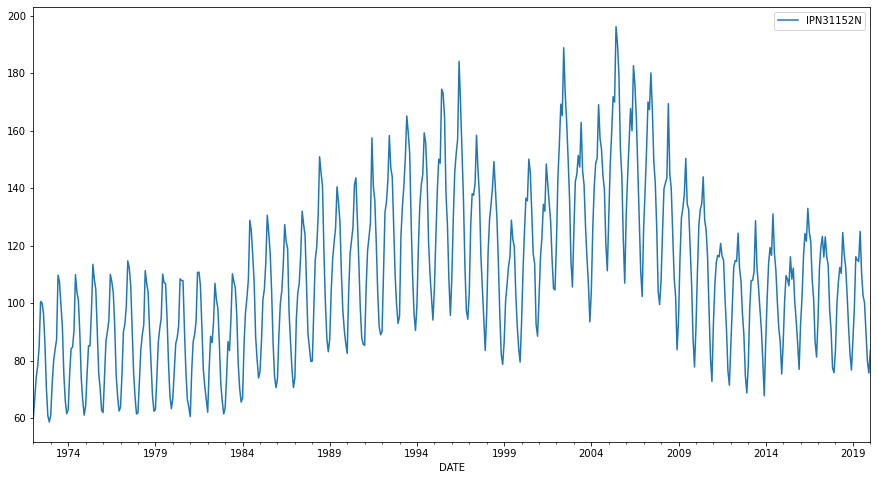

In [280]:
df.plot(figsize = (15,8))
plt.show()

### Seasonality decomposition

Since the Moving Average model works mostly for non-seasonal data, we need to check for any seasonality in our time series and decompose it.

We use the Dickey Fuller Test for testing the seasonality and if the ADF Statistic value is positive, it means that the data has seasonality.

#### Dickey Fuller Test
The Dickey Fuller test is a common statistical test used to test whether a given Time series is stationary or not. The Augmented Dickey Fuller (ADF) test expands the Dickey-Fuller test equation to include high order regressive process in the model. We can implement the ADF test via the **adfuller()** function. It returns the following outputs:

    1. adf : float
> The test statistic.

    2. pvalue : float
> MacKinnon's approximate p-value based on MacKinnon(1994, 2010). It is used alongwith the test statistic to reject or accept the null hypothesis.

    3. usedlag : int
> Number of lags considered for the test

    4. critical values : dict
> Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010).

For more information on the adfuller() function [click here](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)

In [281]:
def dickeyFuller(df,target):
    
    # Applying Dickey Fuller Test
    X = df.values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Number of lags used: %d' % result[2])
    print('Critical Values:')
    for key, value in result[4].items():
           print('\t%s: %.3f' % (key, value))
    
    
    # Decomposing Seasonality if it exists
    if result[0]>0:
        df[target] = df[target].rolling(12).mean()
    
    return df

To remove the seasonality we use the rolling mean technique for smoothing our data and decomposing any seasonality.
This method provides rolling windows over the data. On the resulting windows, we can perform calculations using a statistical function (in this case the mean) in order to decompose the seasonality.

For more information about rolling function [click here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)

In [282]:
df = dickeyFuller(df,target)

ADF Statistic: -1.758009
p-value: 0.401499
Number of lags used: 19
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


### Autocorrelation Plot


We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.
A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. 

An autocorrelation plot shows whether the elements of a time series are positively correlated, negatively correlated, or independent of each other. 
The plot shows the value of the autocorrelation function (acf) on the vertical axis ranging from –1 to 1.
There are vertical lines (a “spike”) corresponding to each lag and the height of each spike shows the value of the autocorrelation function for the lag.

[API](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)

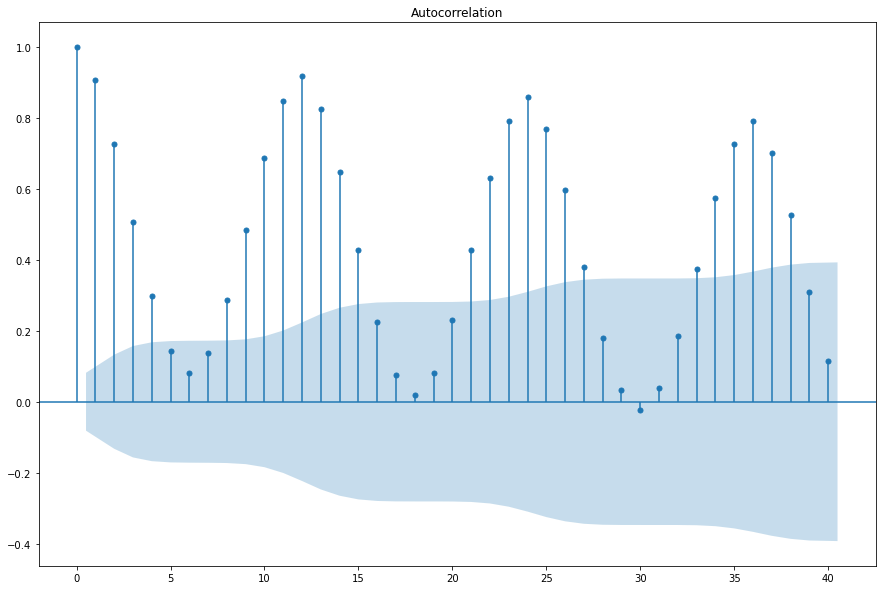

In [283]:
x = plot_acf(df, lags=40)
x.set_size_inches(15, 10, forward=True)
plt.show()

### Partial Autocorrelation Plot

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags. By examining the spikes at each lag we can determine whether they are significant or not. A significant spike will extend beyond the significant limits, which indicates that the correlation for that lag doesn't equal zero.

[API](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html)


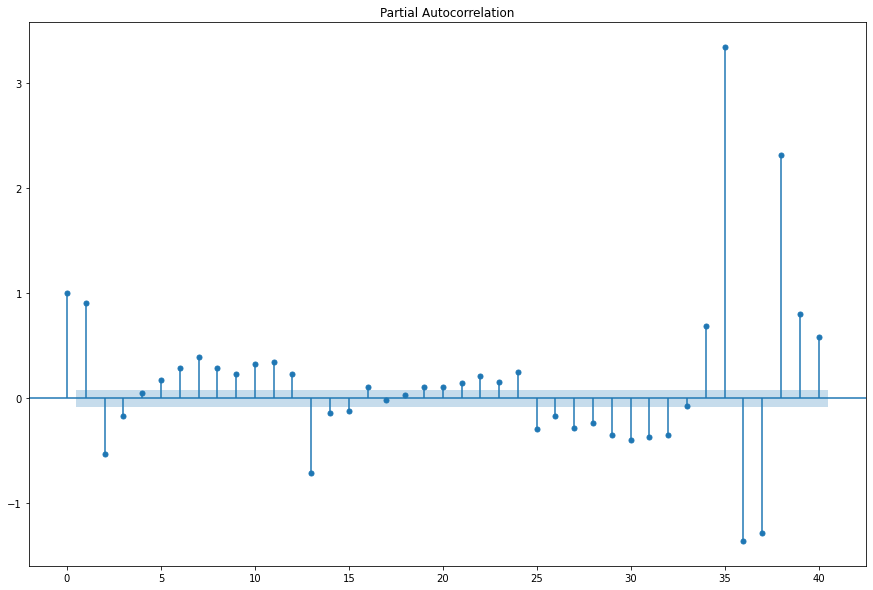

In [284]:
y = plot_pacf(df, lags=40)
y.set_size_inches(15, 10, forward=True)
plt.show()

### Data Splitting

Since we are using a univariate dataset, we can directly split our data into training and testing subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [285]:
size = int(len(df)*0.9)
df_train, df_test = df.iloc[:size], df.iloc[size:]

### Model

Autoregressive (AR) modeling is one of the technique used for time-series analysis.It is training a regression model on the value of response variable itself. Autoregressive is made of the word, Auto and Regressive which represents the linear regression on itself (auto). 

In context of time-series forecasting, autoregressive modeling will mean creating the model where the response variable Y will depend upon the previous values of Y at a pre-determined constant time lag. The time lag can be daily (or 2, 3, 4… days), weekly, monthly etc.

Yt=β0+β1∗Yt−1+errort
In the above model, the value at the last time lag is taken. If the time lag is weekly, the Yt−1 will represent the value of Y of the last week. Such an AR models where the value of response variable of just one time lag is taken are called as AR models of first model or AR (1) models.

Refer [API](https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoReg.html) for parameters

In [292]:
result = AutoReg(df_train[target],lags=[1,2,35,38]).fit()

### Model Summary

After fitting the training data into our Auto Regressive model and training it, we can take a look at a brief summary of our model by using the **summary()** function. The followings aspects are included in our model summary:

1. Basic Model Details: The first column of our summary table contains the basic details regarding our model such as: 
    
        a. Name of dependent variable    
        b. Model used along with parameters    
        c. Date and time of model deployment    
        d. Time Series sample used to train the model
    
        
2. Probablistic Statistical Measures: The second column gives the values of the probablistic measures obtained by our model:
    
       a. Number of observations
   
       b. Log-likelihood, which comes from Maximum Likelihood Estimation, a technique for finding or optimizing the
       parameters of a model in response to a training dataset.
   
       c. Standard Deviation of the innovations
   
       d. Akaike Information Criterion (AIC), which is derived from frequentist probability.
   
       e. Bayesian Information Criterion (BIC), which is derived from Bayesian probability.
   
       f. Hannan-Quinn Information Criterion (HQIC), which is an alternative to AIC and is derived using the log-likelihood and 
       the number of observartions.

In [293]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              IPN31152N   No. Observations:                  519
Model:             Restr. AutoReg(38)   Log Likelihood               -1604.948
Method:               Conditional MLE   S.D. of innovations              6.806
Date:                Tue, 07 Sep 2021   AIC                              3.860
Time:                        23:09:27   BIC                              3.913
Sample:                    03-01-1975   HQIC                             3.881
                         - 03-01-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.7708      1.501      0.514      0.608      -2.171       3.713
IPN31152N.L1      0.7785      0.037     21.016      0.000       0.706       0.851
IPN31152N.L2      0.1699      0.042      4.051      0.000       0.088       0.252
IPN31152N.L35     0.4201      0.018     23.408      0.000       0.385       0.455
IPN31152N.L38    -0.3750      0.023    -16.267      0.000      -0.420      -0.330
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.9840           -0.1754j            0.9995           -0.0281
AR.2             0.9840           +0.1754j            0.9995            0.0281
AR.3             1.0043           -0.0000j            1.0043           -0.0000
AR.4             1.0359           -0.0000j            1.0359           -0.0000
AR.5             0.9390           -0.3441j            1.0001           -0.0559
AR.6             0.9390           +0.3441j            1.0001            0.0559
AR.7             0.8656           -0.5031j            1.0012           -0.0838
AR.8             0.8656           +0.5031j            1.0012            0.0838
AR.9             0.7660           -0.6474j            1.0030           -0.1117
AR.10            0.7660           +0.6474j            1.0030            0.1117
AR.11            0.6430           -0.7729j            1.0054           -0.1396
AR.12            0.6430           +0.7729j            1.0054            0.1396
AR.13            0.5001           -0.8759j            1.0086           -0.1674
AR.14            0.5001           +0.8759j            1.0086            0.1674
AR.15            0.3413           -0.9535j            1.0128           -0.1953
AR.16            0.3413           +0.9535j            1.0128            0.1953
AR.17            0.1711           -1.0039j            1.0184           -0.2231
AR.18            0.1711           +1.0039j            1.0184            0.2231
AR.19           -0.0059           -1.0261j            1.0261           -0.2509
AR.20           -0.0059           +1.0261j            1.0261            0.2509
AR.21           -0.1856           -1.0208j            1.0376           -0.2786
AR.22           -0.1856           +1.0208j            1.0376            0.2786
AR.23           -1.0161           -0.0884j            1.0199           -0.4862
AR.24           -1.0161           +0.0884j            1.0199            0.4862
AR.25           -0.9874           -0.2632j            1.0219           -0.4585
AR.26           -0.9874           +0.2632j            1.0219            0.4585
AR.27           -0.9310           -0.4316j            1.0262           -0.4309
AR.28           -0.9310           +0.4316j            1.0262            0.4309
AR.29           -0.8486           -0.5901j            1.0

#### Simple Forecasting

In [294]:
df_train.tail()

IPN31152N
DATE                 
2014-11-01    86.5723
2014-12-01    75.3749
2015-01-01    85.5769
2015-02-01   100.5580
2015-03-01   109.5789

### Predictions

By specifying the start and end time for our predictions, we can easily predict the future points in our time series with the help of our model.

In [301]:
start_date = df_test.index[0]
end_date = df_test.index[-1]

df_pred = result.predict(start = start_date, end = end_date)
df_pred.head()

2015-04-01    113.961582
2015-05-01    118.166674
2015-06-01    116.265009
2015-07-01    113.622962
2015-08-01    102.840197
Freq: MS, dtype: float64

## Model Accuracy

Since the Moving Average model is implemented above with the help of ARMA class which does not provide a predefine "**score**" function like other class models, we need to use other metrics to find a measure of our model accuracy.

We will use the three most popular metrics for model evaluation: Mean absolute error (MAE), Mean squared error (MSE), or Root mean squared error (RMSE).

In [302]:
test = df_test[target]
print("Mean Absolute Error {:.2f}".format(mean_absolute_error(test,df_pred)))
print("Mean Squared Error {:.2f}".format(mean_squared_error(test,df_pred)))
print("Root Mean Squared Error {:.2f}".format(np.sqrt(mean_squared_error(test,df_pred))))

Mean Absolute Error 6.28
Mean Squared Error 53.68
Root Mean Squared Error 7.33


## Predictions Plot

First we make use of plot to plot the predicted values returned by our model based on the test data.
After that we plot the actual test data to compare our predictions.

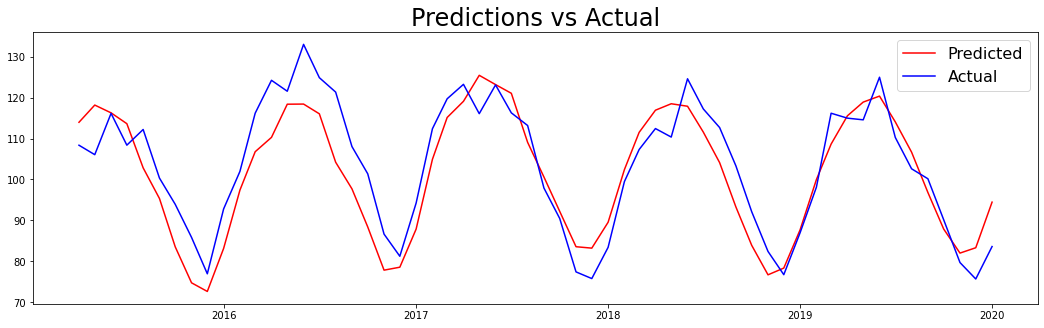

In [305]:
plt.figure(figsize=(18,5))
plt.plot(df_pred[start_date:end_date], color = "red")
plt.plot(df_test, color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.plot(fontsize="x-large")
plt.legend(['Predicted','Actual'],fontsize = 16)
plt.show()

#### Creator: Aishwarya Guntoju , Github: [Profile](https://github.com/DSAishwaryaG)